In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['formatting/vmc_colors.mplstyle','formatting/publication.mplstyle'])
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


In this notebook, we explore the relationship between synthesis temperature and several scalar predictors. We show that these predictors are insufficient to fully describe reaction temperature. We additionally show that no clear subset of reactions proceeds colder than 100 C.

1. [Adding Additional Scalar Predictors](#adding-additional-scalar-predictors)
2. [Predictor Covariance Analysis](#predictor-covariance-analysis)
3. [Linear Regression](#linear-regression)

In [6]:
df = pd.read_excel('../multicompound_data/combined_patent_entries.xlsx')

#### Adding Additional Scalar Predictors

In [7]:
df["G298"] = df["enthalpy_rxn"]-298*df["entropy_rxn"]
df["GT"] = df["enthalpy_rxn"]-(df['temperatures_c']+273)*df["entropy_rxn"]
df["BoilingPoint_atPressure_Antoine"] = df["B"]/(df["A"] - np.log10(df["pressures_bar"])) - df["C"] -273

#### Predictor Covariance Analysis

We understand that many of our scalar properties are likely correlated, and we wish to not confuse our linear regression results with correlated predictors. Here, we plot the covariance matrix of all of our scalar predictors. Each predictor has been normalized to have a mean 0 and standard deviation of 1.

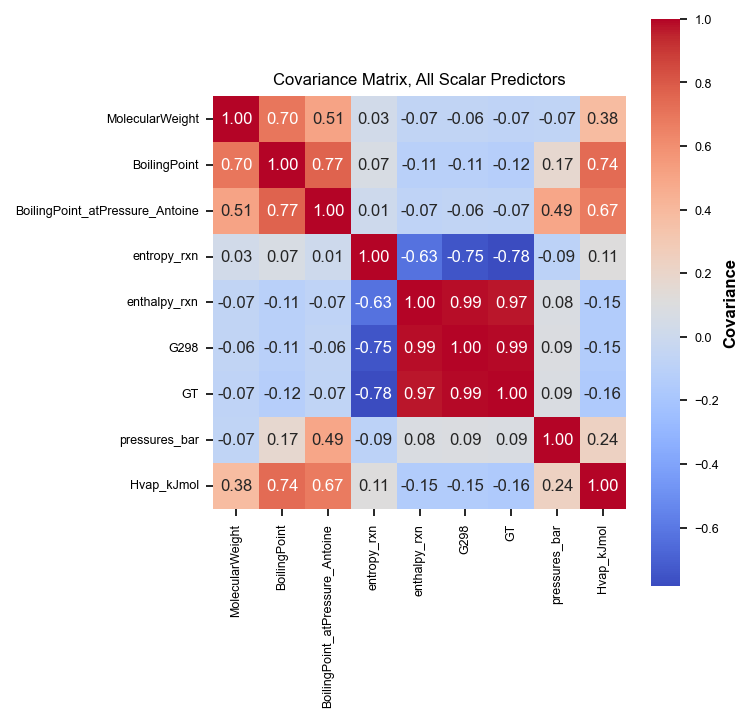

In [12]:
subset_cols = ['MolecularWeight',"BoilingPoint",'BoilingPoint_atPressure_Antoine', 'entropy_rxn', 'enthalpy_rxn' ,'G298', 'GT', "pressures_bar","Hvap_kJmol" ]
# Standardize: zero mean, unit variance
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[subset_cols])
normalized_df = pd.DataFrame(normalized_data, columns=subset_cols)
cov_matrix = normalized_df.cov()

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'label': 'Covariance'})
plt.title("Covariance Matrix, All Scalar Predictors")
plt.tight_layout()
plt.show()


From this information, we examined any set of variables with a pair-wise covariance exceeding 0.75 and ejected one of the two when there was a physical basis for this covariance. This yielded a smaller set of predictors, whos covariance matrix is displayed below.

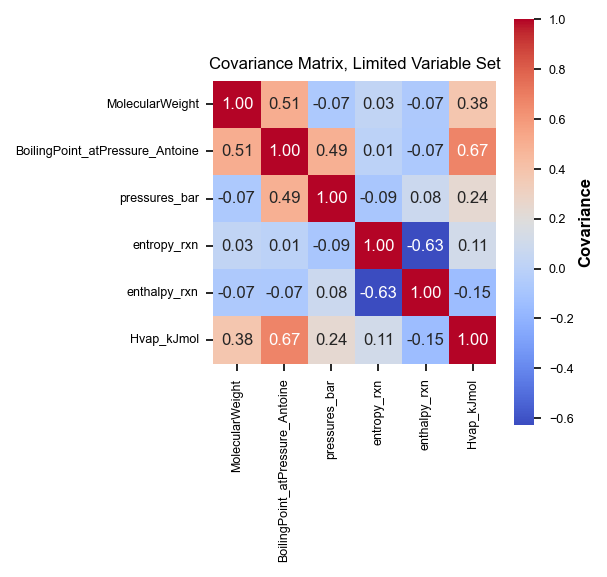

In [15]:
subset_cols = ['MolecularWeight', "BoilingPoint_atPressure_Antoine","pressures_bar",'entropy_rxn', 'enthalpy_rxn', "Hvap_kJmol"  ]  # replace with your actual metric names

# Standardize: zero mean, unit variance
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[subset_cols])
normalized_df = pd.DataFrame(normalized_data, columns=subset_cols)
cov_matrix = normalized_df.cov()

# Plot heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'label': 'Covariance'})
plt.title("Covariance Matrix, Limited Variable Set")
plt.tight_layout()
plt.show()

#### Linear Regression

We then used these 6 scalar predictors in a simple linear regression to look for any strong relationships.

In [18]:
# --- Step 1: Define predictors and target ---
subset_cols = ['MolecularWeight', 'BoilingPoint_atPressure_Antoine', 'pressures_bar', 'entropy_rxn', 'enthalpy_rxn', 'Hvap_kJmol']
df_dropped = df.dropna(subset=subset_cols, ignore_index=True)
X = df_dropped[subset_cols]
y = df_dropped['temperatures_c']

# --- Step 2: Standardize predictors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# --- Step 4: Create DataFrame for statsmodels ---
X_scaled_df = pd.DataFrame(X_scaled, columns=subset_cols)
X_scaled_df = sm.add_constant(X_scaled_df)  # adds intercept term

# --- Step 5: Fit model and view stats ---
model = sm.OLS(y, X_scaled_df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         temperatures_c   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     20.50
Date:                Fri, 27 Jun 2025   Prob (F-statistic):           2.46e-22
Time:                        13:38:33   Log-Likelihood:                -4909.7
No. Observations:                 773   AIC:                             9833.
Df Residuals:                     766   BIC:                             9866.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Overall, this linear regression summary indicates that with an R^2 of 0.138, these predictors are nowhere near sufficient to capture the variance in temperature. This incredibly low R^2 value also indicates that more complicated models could still not represent this behavior. Despite this insufficiency, most factors are still "significant."

Our next question: does this linear regression indicate that any one subset of reactions is likely to run at cooler temperatures? We address this question simply by using this weak model to predict operating temperature (below).

We see that this model is incapable of predicting any subset of reaction types to occur below 100 C. Thus, even though there are significant relationships between temperature and our predictors, we claim that the main driver of temperature is outside of our dataset (and thus encompassed in the constant of the linear regression)

Text(0.5, 0, 'Predicted Synthesis Temperature')

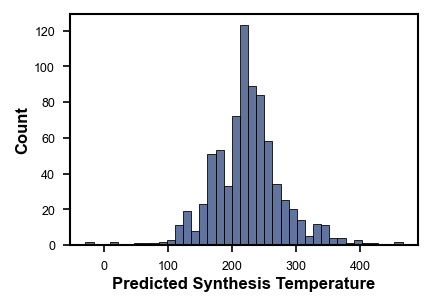

In [30]:
plt.figure(figsize=(3, 2))
predicted_temps = model.predict(X_scaled_df)
sns.histplot(predicted_temps)

plt.xlabel("Predicted Synthesis Temperature")